In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [28]:
df =pd.read_csv(r"c:\Users\GLXTCH\Documents\diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# DATA CLEANING

In [29]:
# Replace zeros in Insulin using median grouped by Outcome
df['Insulin'] = df.groupby('Outcome')['Insulin'].transform(
    lambda x: x.replace(0, x[x != 0].median())
)

# Replace zeros in other columns using overall median
cols_to_fix = ['BloodPressure', 'SkinThickness', 'BMI']
for col in cols_to_fix:
    median_val = df[df[col] != 0][col].median()
    df[col] = df[col].replace(0, median_val)

# Ensure correct data types
numeric_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for col in numeric_cols:
    df[col] = df[col].astype(float)

# Outcome should be int
df['Outcome'] = df['Outcome'].astype(int)

# Quick check
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0
2,8.0,183.0,64.0,29.0,169.5,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


# EXPLORATORY DATA ANALYSIS (EDA)

In [30]:
import os
output_folder= 'visuals'
os.makedirs(output_folder, exist_ok=True)

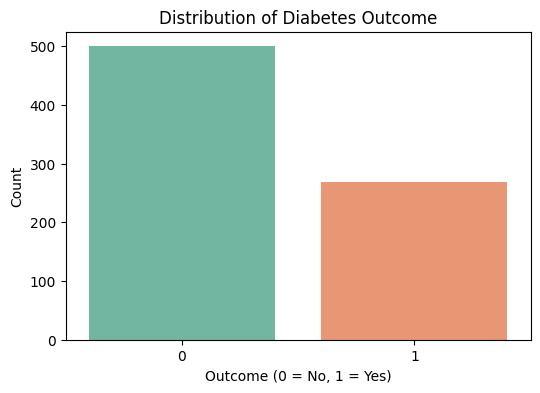

In [31]:
# Outcome distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', hue='Outcome', data=df, palette='Set2', legend=False)
plt.title('Distribution of Diabetes Outcome')
plt.xlabel('Outcome (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.savefig(f'{output_folder}/Distribution of Diabetes Outcome.png', dpi=300)
plt.show()

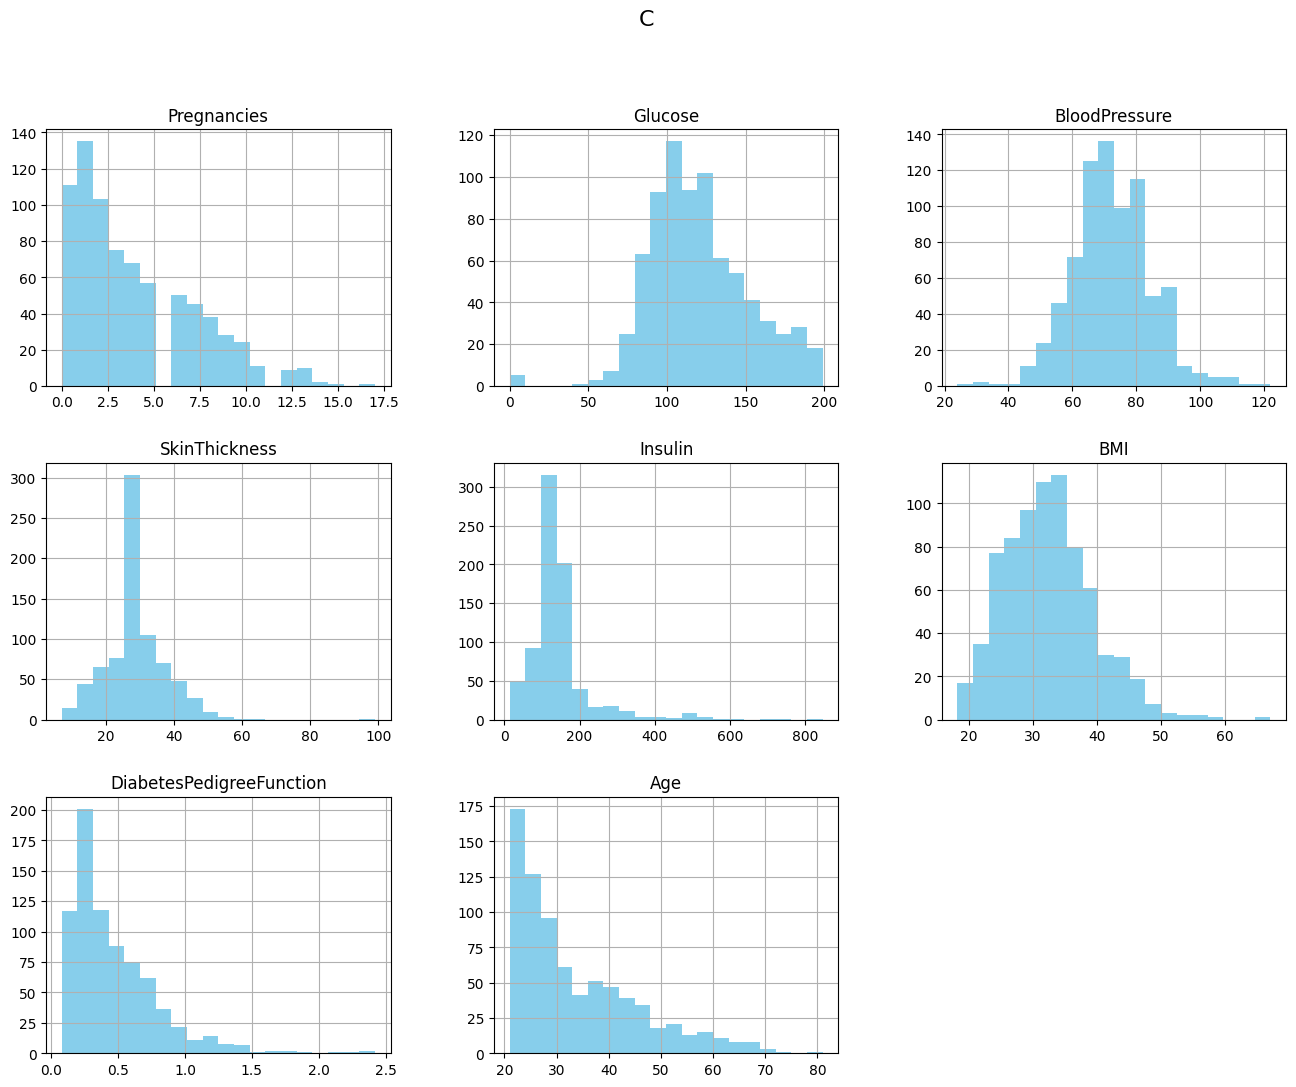

In [32]:
# Feature distributions
numeric_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

df[numeric_cols].hist(figsize=(16,12), bins=20, color='skyblue')
plt.suptitle('C', fontsize=16)
plt.savefig(f'{output_folder}/Feature distributions.png', dpi=300)
plt.show()

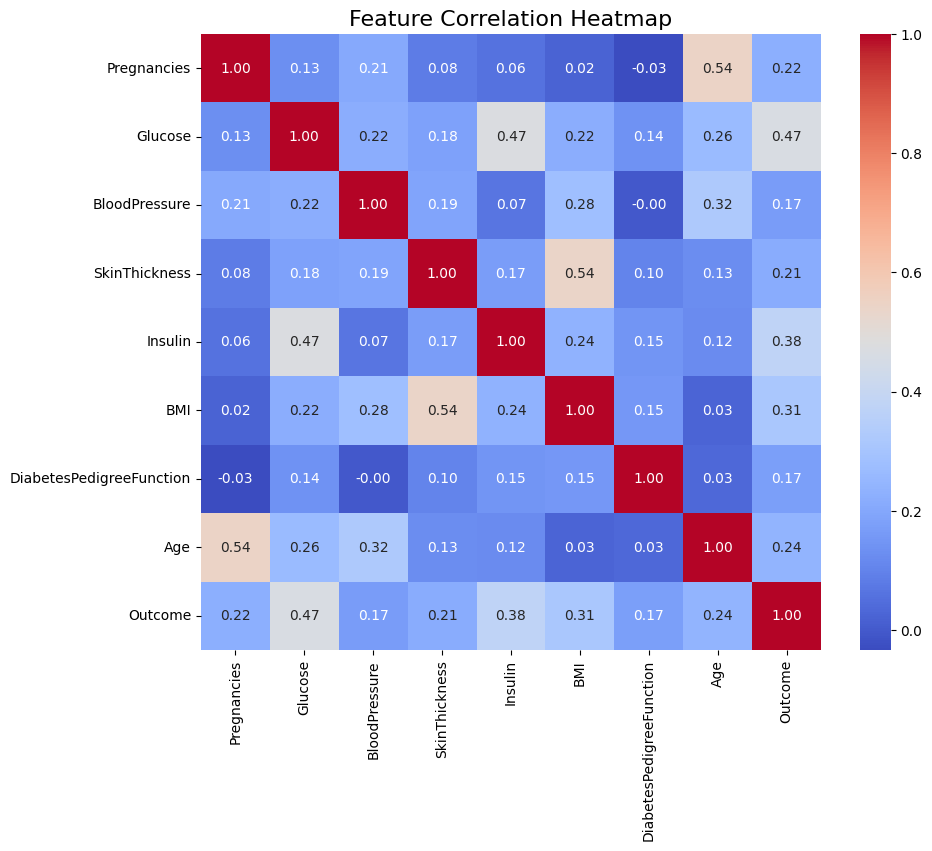

In [33]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.savefig(f'{output_folder}/Feature Correlation Heatmap.png', dpi=300)
plt.show()

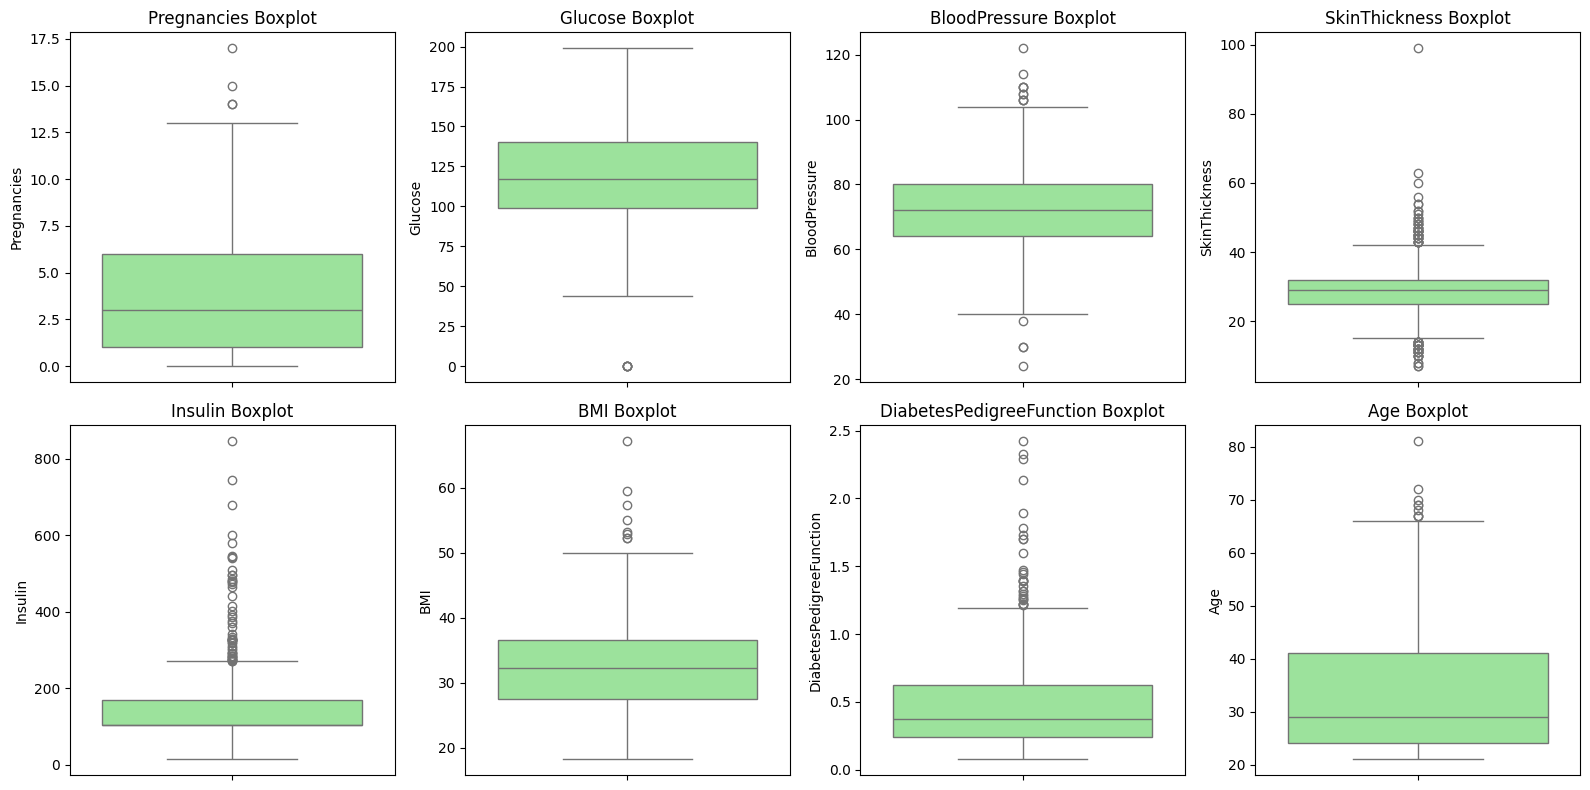

In [34]:
# Boxplots to detect outliers
plt.figure(figsize=(16,8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.savefig(f'{output_folder}/Boxplots to detect outliers.png', dpi=300)
plt.show()

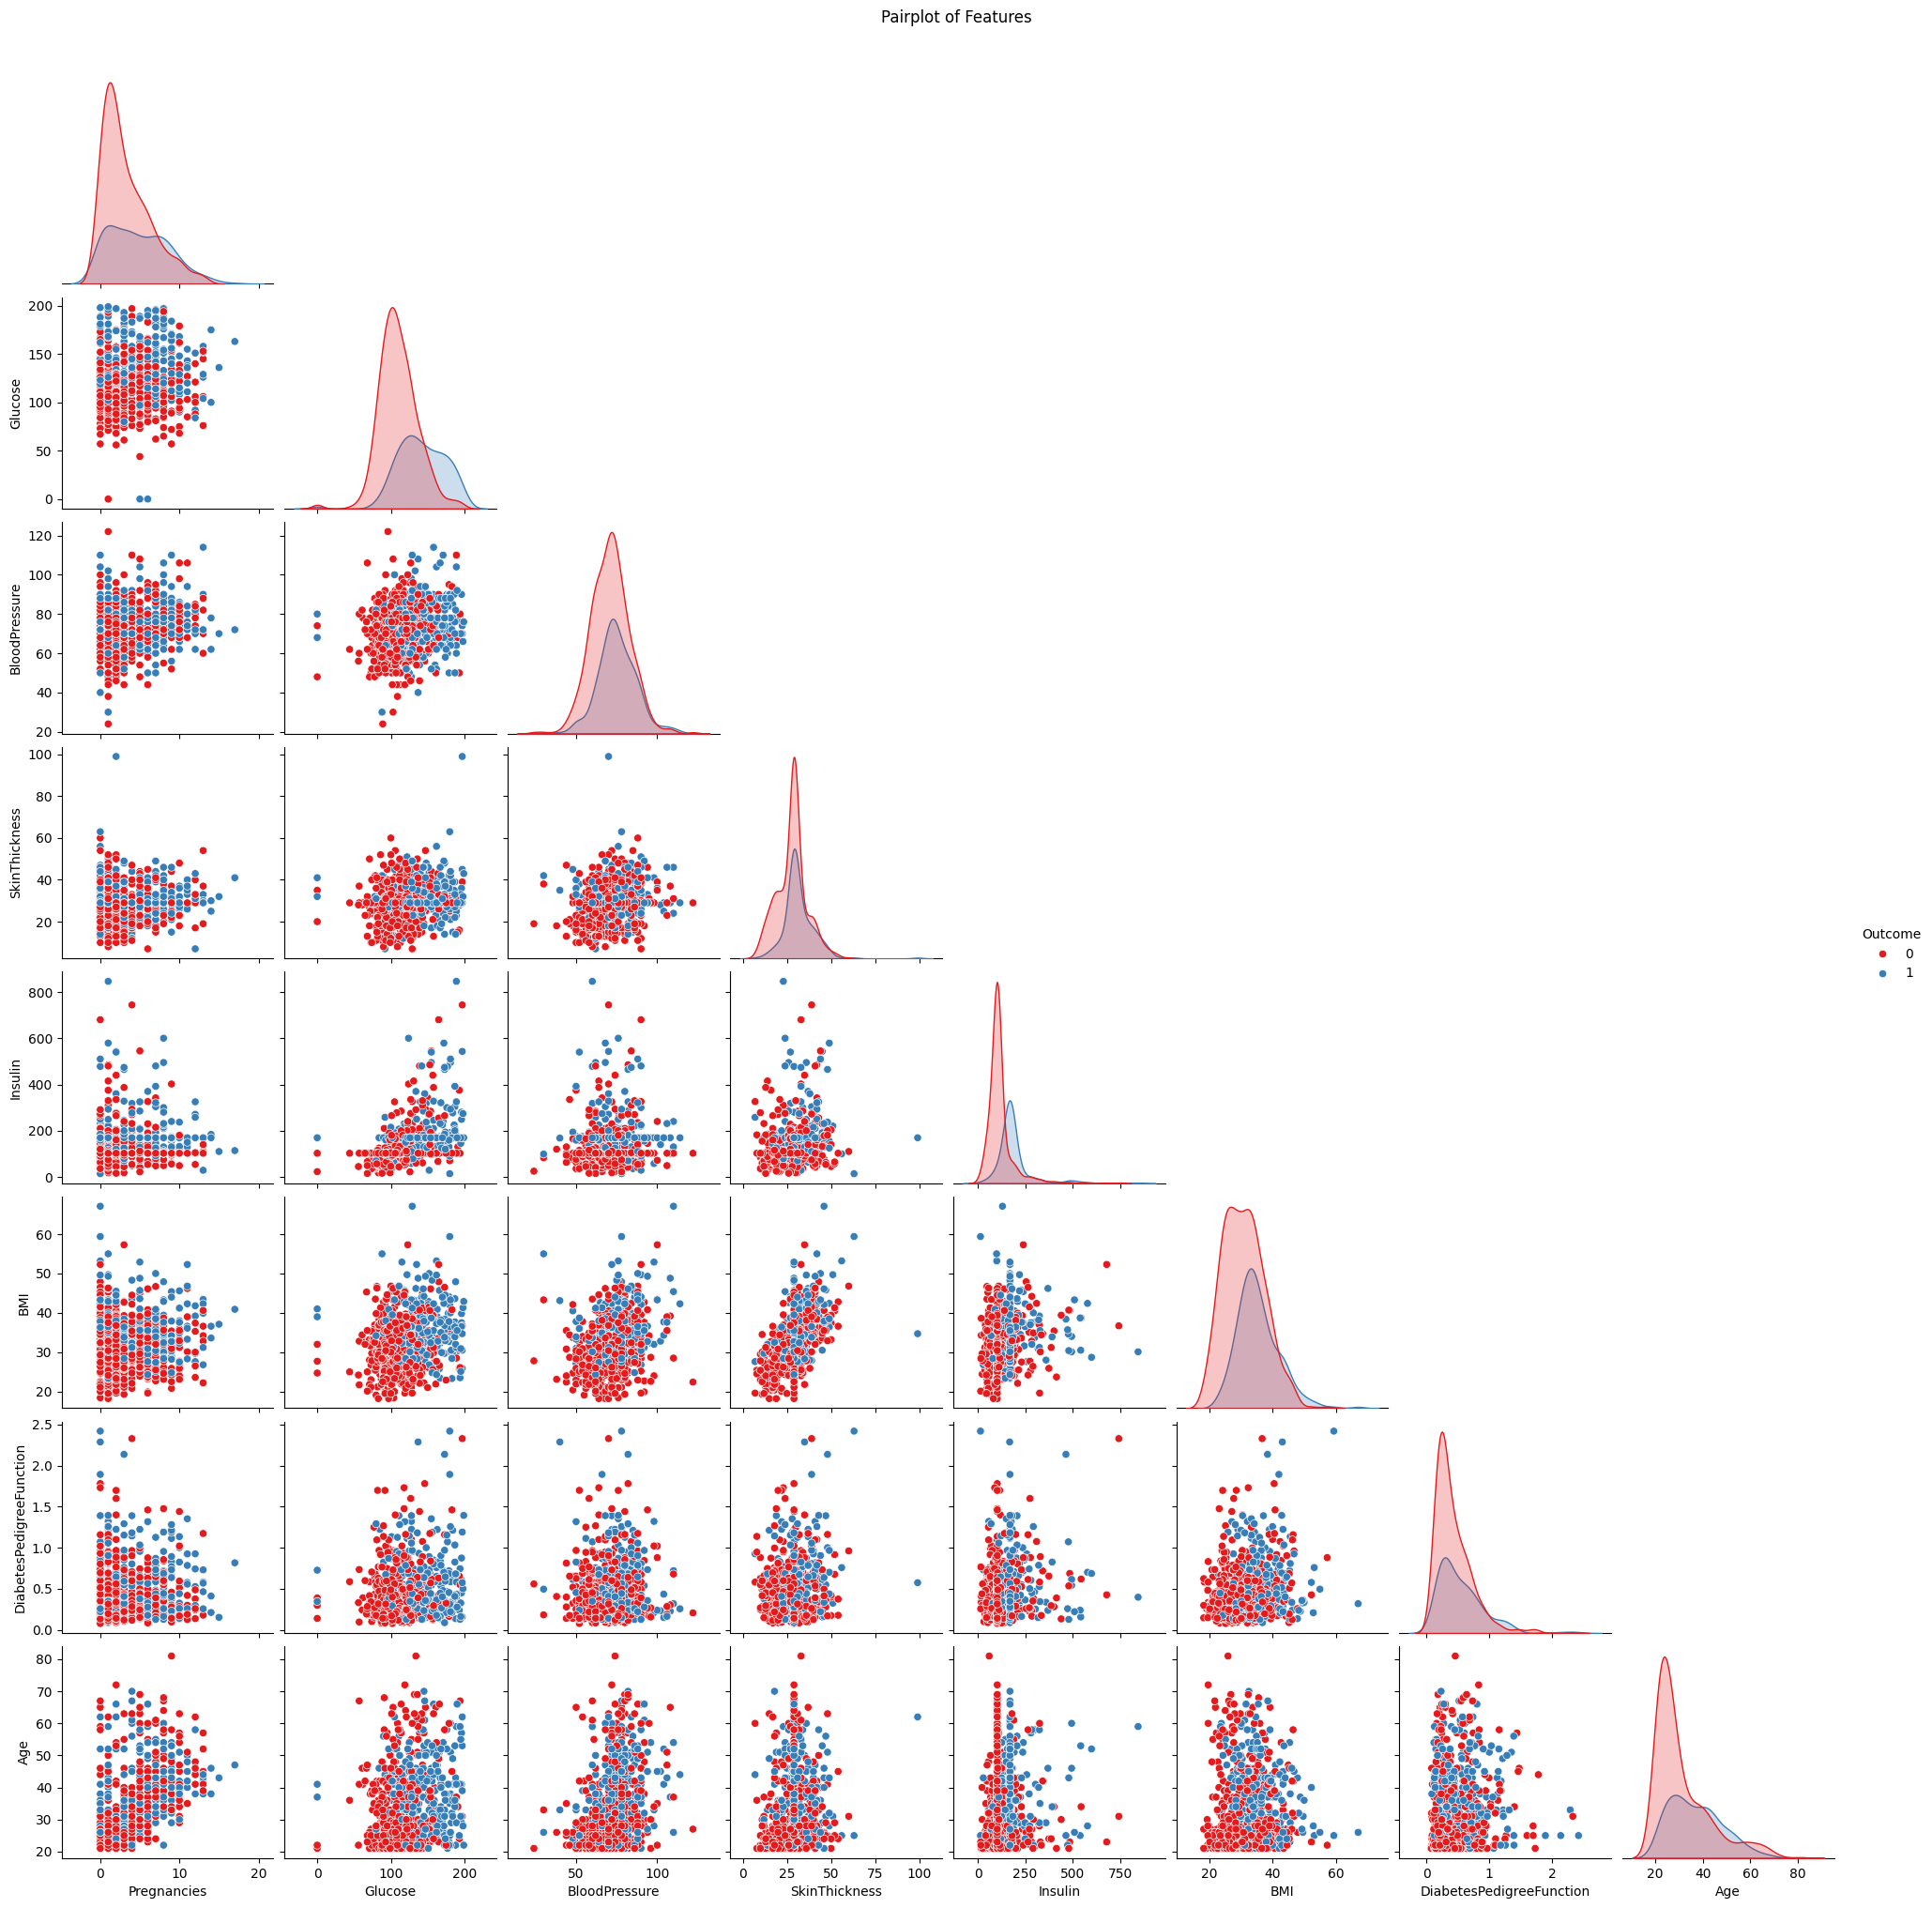

In [35]:
# Pairplot for feature relationships colored by Outcome
sns.pairplot(df, hue='Outcome', vars=numeric_cols, palette='Set1', corner=True)
plt.suptitle('Pairplot of Features', y=1.02)
plt.savefig(f'{output_folder}/Pairplot of Features.png', dpi=300)
plt.show()

# OUTLIER DETECTION & HANDLING

In [36]:
# Features to check for outliers
features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

df_clean = df.copy()

def cap_outliers_classwise(data, col, outcome_col='Outcome'):
    for cls in data[outcome_col].unique():
        subset = data[data[outcome_col] == cls]
        
        Q1 = subset[col].quantile(0.25)
        Q3 = subset[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Winsorization: cap values to bounds
        data.loc[(data[outcome_col] == cls) & (data[col] < lower_bound), col] = lower_bound
        data.loc[(data[outcome_col] == cls) & (data[col] > upper_bound), col] = upper_bound
    
    return data


# Apply class-wise outlier capping to all selected features
for feature in features:
    df_clean = cap_outliers_classwise(df_clean, feature)

df = df_clean.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.5,33.6,0.62700,50.0,1
1,1.0,85.0,66.0,29.0,102.5,26.6,0.35100,31.0,0
2,8.0,183.0,64.0,29.0,169.5,23.3,0.67200,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.16700,21.0,0
4,0.0,137.0,47.0,35.0,169.5,43.1,1.42625,33.0,1


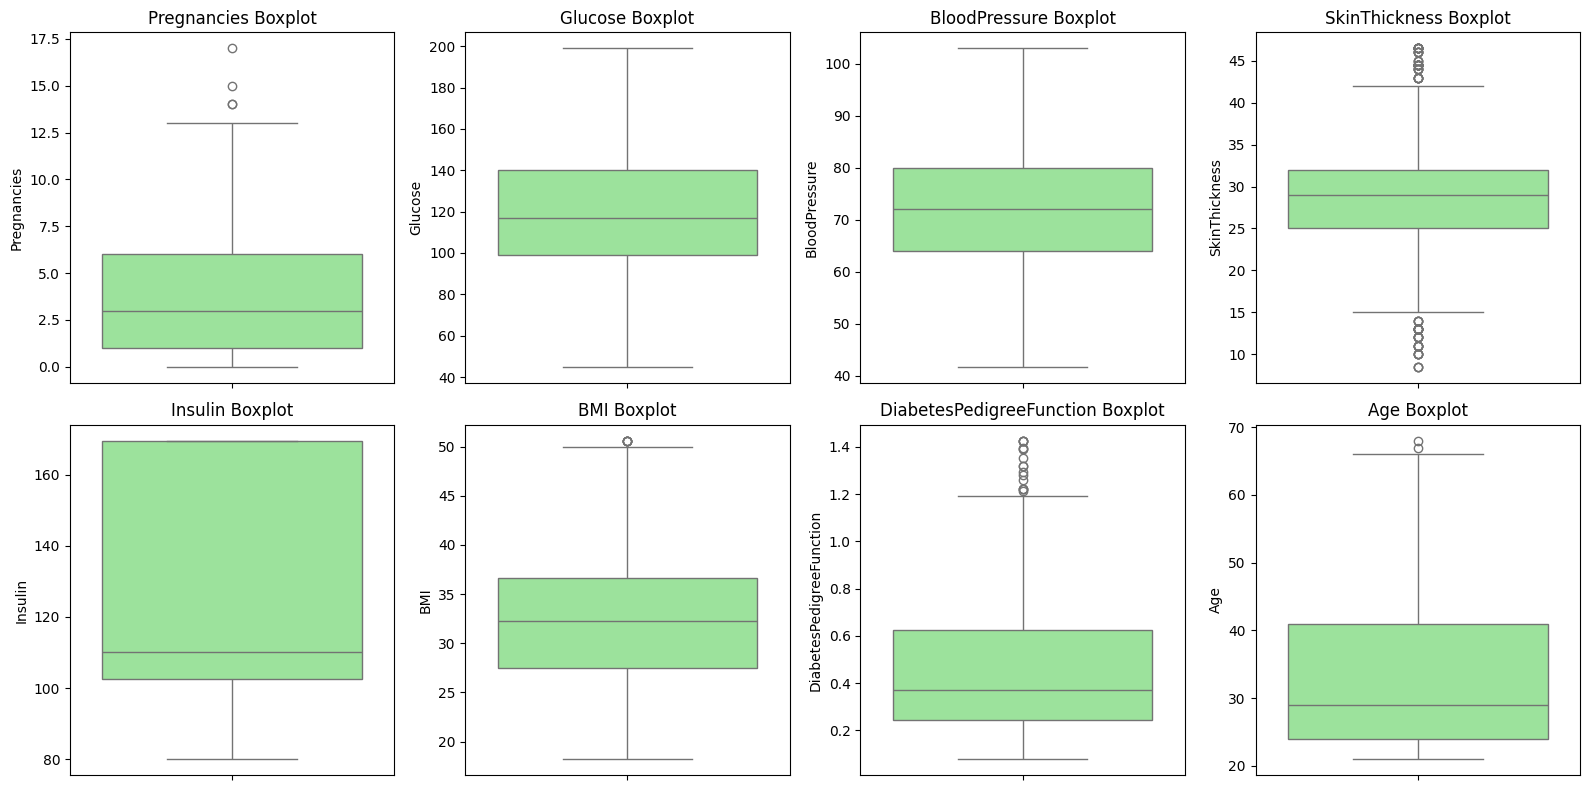

In [37]:
# Boxplots to detect outliers
plt.figure(figsize=(16,8))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col], color='lightgreen')
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.savefig(f'{output_folder}/Boxplots to detect outliers.png', dpi=300)
plt.show()

# FEATURE ENGINEERING

In [38]:
df_fe = df.copy()

# SCALING
scaler = StandardScaler()

num_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

df_fe[num_cols] = scaler.fit_transform(df_fe[num_cols])

In [39]:
# FEATURE CREATION

# BMI Category
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df_fe['BMI_Category'] = df['BMI'].apply(bmi_category)


# Age Group
def age_group(age):
    if age < 30:
        return '18-29'
    elif age < 45:
        return '30-44'
    elif age < 60:
        return '45-59'
    else:
        return '60+'

df_fe['Age_Group'] = df['Age'].apply(age_group)


# Glucose-to-Insulin Ratio
df_fe['GIR'] = df['Glucose'] / (df['Insulin'] + 1)


# Body Fat Index (approximation)
df_fe['BFI'] = df['BMI'] * (df['Age'] / 100)


# Interaction Features
df_fe['BMI_Age'] = df['BMI'] * df['Age']
df_fe['Glucose_BMI'] = df['Glucose'] * df['BMI']
df_fe['Insulin_Skin'] = df['Insulin'] * df['SkinThickness']

In [40]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded = encoder.fit_transform(df_fe[['BMI_Category', 'Age_Group']])
encoded_df = pd.DataFrame(
    encoded, 
    columns=encoder.get_feature_names_out(['BMI_Category', 'Age_Group'])
)

df_fe = pd.concat(
    [df_fe.drop(['BMI_Category', 'Age_Group'], axis=1), encoded_df],
    axis=1
)

df_fe.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,GIR,BFI,BMI_Age,Glucose_BMI,Insulin_Skin,BMI_Category_Obese,BMI_Category_Overweight,BMI_Category_Underweight,Age_Group_30-44,Age_Group_45-59,Age_Group_60+
0,0.639947,0.879025,-0.029985,0.765033,1.296783,0.180863,0.585756,1.519692,1,0.868035,16.800,1680.0,4972.8,5932.5,1.0,0.0,0.0,0.0,1.0,0.0
1,-0.844885,-1.173915,-0.550399,0.008537,-0.662212,-0.869245,-0.375924,-0.180741,0,0.821256,8.246,824.6,2261.0,2972.5,0.0,1.0,0.0,1.0,0.0,0.0
2,1.233880,2.019547,-0.723870,0.008537,1.296783,-1.364297,0.742552,-0.091244,1,1.073314,7.456,745.6,4263.9,4915.5,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.844885,-1.043569,-0.550399,-0.747959,-0.910741,-0.644222,-1.017044,-1.075706,0,0.936842,5.901,590.1,2500.9,2162.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.141852,0.520575,-2.198377,0.765033,1.296783,1.606011,3.370620,-0.001748,1,0.803519,14.223,1422.3,5904.7,5932.5,1.0,0.0,0.0,1.0,0.0,0.0


# TRAIN/TEST SPLIT

In [41]:
# Separate Features (X) and Target (y)
X = df_fe.drop('Outcome', axis=1)
y = df_fe['Outcome']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling (Standardization)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [42]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# MODEL BUILDING & EVALUATION

--- Logistic Regression ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Confusion Matrix:


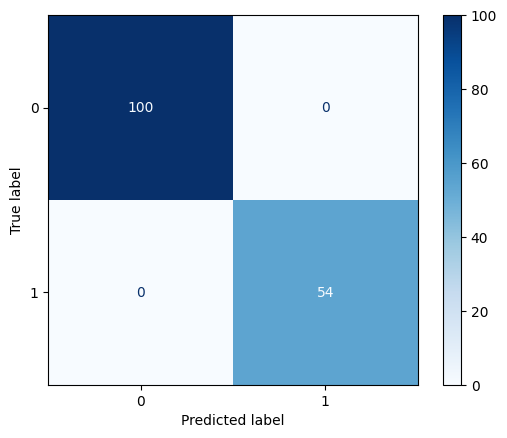

--- Random Forest ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
Confusion Matrix:


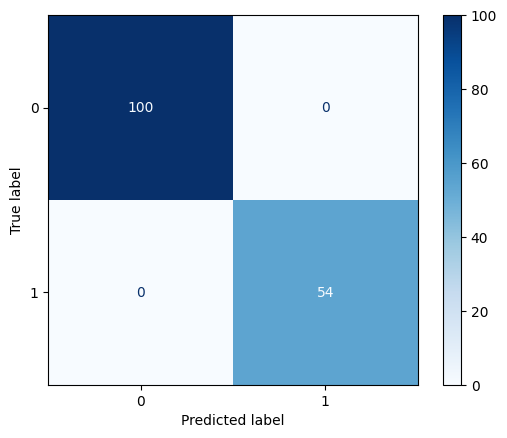

In [43]:
# Assuming your target variable is y_train
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, weights))

# Logistic Regression
lr = LogisticRegression(class_weight=class_weights_dict, random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:,1]

# Random Forest
rf = RandomForestClassifier(class_weight=class_weights_dict, random_state=42, n_estimators=200)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:,1]

# Evaluation Function
def evaluate_model(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", round(accuracy_score(y_true, y_pred),3))
    print("Precision:", round(precision_score(y_true, y_pred),3))
    print("Recall:", round(recall_score(y_true, y_pred),3))
    print("F1 Score:", round(f1_score(y_true, y_pred),3))
    print("ROC-AUC:", round(roc_auc_score(y_true, y_prob),3))
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.savefig(f'{output_folder}/Logistic Regression.png', dpi=300)
    plt.show()
    
# Evaluate All Models
evaluate_model(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")

# HYPERPARAMETER TUNING + CROSS-VALIDATION

In [44]:
# Define model
lr = LogisticRegression(class_weight=class_weights_dict, random_state=42, max_iter=1000)

# Define hyperparameter grid
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# GridSearchCV with 5-fold CV
lr_grid = GridSearchCV(
    estimator=lr,
    param_grid=lr_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on scaled training data
lr_grid.fit(X_train_scaled, y_train)

print("Best Logistic Regression Params:", lr_grid.best_params_)
print("Best ROC-AUC:", lr_grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Logistic Regression Params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC-AUC: 1.0


In [45]:
rf = RandomForestClassifier(class_weight=class_weights_dict, random_state=42)

rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_params,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_scaled, y_train)

print("Best Random Forest Params:", rf_grid.best_params_)
print("Best ROC-AUC:", rf_grid.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Random Forest Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best ROC-AUC: 1.0


In [46]:
# Evaluate Best Models on Test Set

# Logistic Regression
best_lr = lr_grid.best_estimator_
y_pred_lr = best_lr.predict(X_test_scaled)
y_prob_lr = best_lr.predict_proba(X_test_scaled)[:,1]

# Random Forest
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
y_prob_rf = best_rf.predict_proba(X_test_scaled)[:,1]

# Evaluation Function
def evaluate(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", round(accuracy_score(y_true, y_pred),3))
    print("Precision:", round(precision_score(y_true, y_pred),3))
    print("Recall:", round(recall_score(y_true, y_pred),3))
    print("F1 Score:", round(f1_score(y_true, y_pred),3))
    print("ROC-AUC:", round(roc_auc_score(y_true, y_prob),3))
    print("\n")

evaluate(y_test, y_pred_lr, y_prob_lr, "Logistic Regression (Tuned)")
evaluate(y_test, y_pred_rf, y_prob_rf, "Random Forest (Tuned)")

--- Logistic Regression (Tuned) ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0


--- Random Forest (Tuned) ---
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0




# FINAL MODEL SELECTION & VISUALIZATION

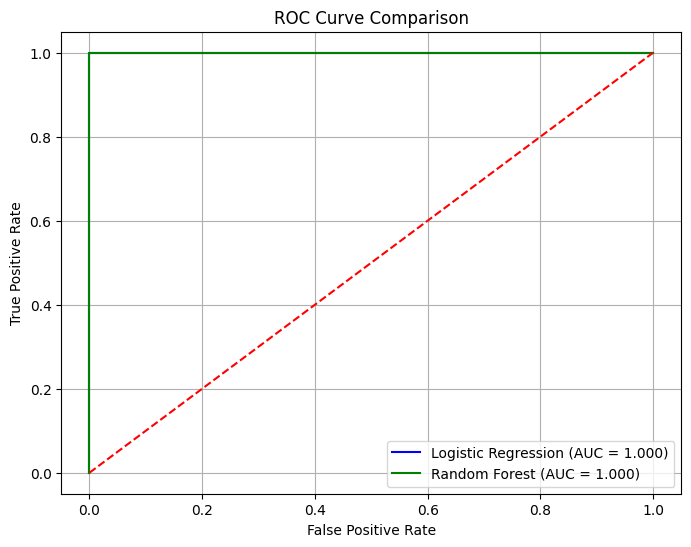

In [47]:
# ROC Curve Visualization

# Compute ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, color='blue', label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig(f'{output_folder}/ROC Curve Visualization.png', dpi=300)
plt.show()

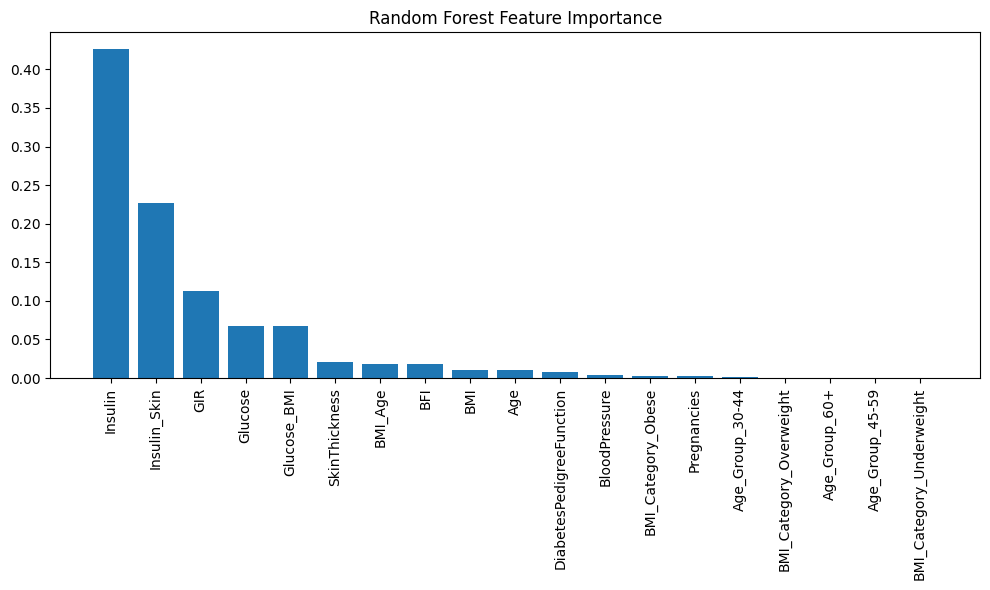

In [48]:
# Feature Importance — Random Forest
importances = best_rf.feature_importances_
features = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(features)), importances[indices], align='center')
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig(f'{output_folder}/Random Forest Feature Importance.png', dpi=300)
plt.show()

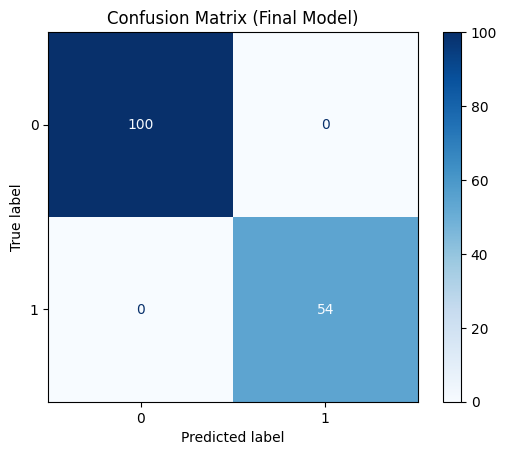

In [49]:
# Confusion Matrix — Final Model

cm = confusion_matrix(y_test, y_pred_rf)





disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Final Model)')
plt.savefig(f'{output_folder}/Confusion Matrix — Final Model.png', dpi=300)
plt.show()